# Exploratory Data Analysis of the Kingston Housing Data - Data Exploration

## Imports & Setup

In [1]:
import numpy as np
import pandas as pd
import math
from plotnine import *
import seaborn as sns#
import matplotlib.pyplot as plt

pd.set_option("display.max_columns", None) # no dots (...) in DataFrame columns

In [2]:
# Load the Data Set
data = pd.read_pickle('King_County_House_prices_dataset_CLEANED.pkl')
# Get the number of rows and columns
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21596 entries, 0 to 21596
Data columns (total 18 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   id             21596 non-null  int64         
 1   date           21596 non-null  datetime64[ns]
 2   price          21596 non-null  float64       
 3   bedrooms       21596 non-null  int64         
 4   bathrooms      21596 non-null  float64       
 5   sqft_living    21596 non-null  int64         
 6   sqft_lot       21596 non-null  int64         
 7   floors         21596 non-null  category      
 8   waterfront     19220 non-null  float64       
 9   condition      21596 non-null  int64         
 10  grade          21596 non-null  category      
 11  sqft_basement  21142 non-null  float64       
 12  yr_built       21596 non-null  int64         
 13  zipcode        21596 non-null  int64         
 14  lat            21596 non-null  float64       
 15  long           2159

## Exploring the factors in relation to price

Let's take a look at what variables influence the price of a house.

### 1. id

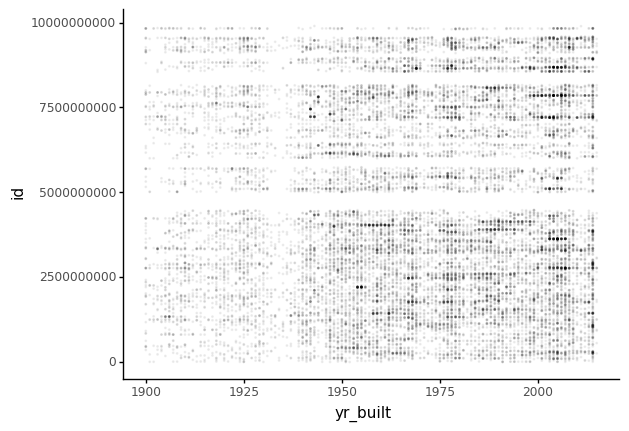

<ggplot: (8782430795489)>

In [3]:
# id vs yr_built
(ggplot(data, aes('yr_built', 'id')) 
+ geom_point(size=0.2, alpha = 0.05)
+ theme_classic())

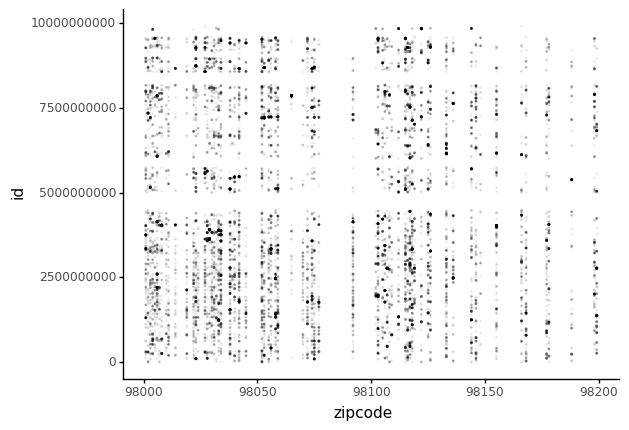

<ggplot: (-9223363254423312440)>

In [4]:
# id vs zipcode
(ggplot(data, aes('zipcode', 'id')) 
+ geom_point(size=0.2, alpha = 0.05)
+ theme_classic())

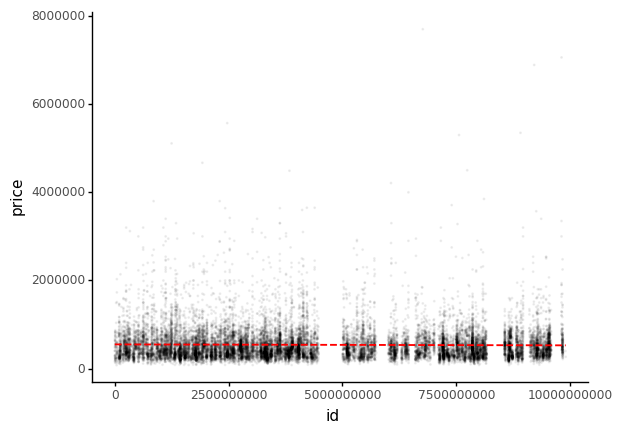

<ggplot: (8782432239799)>

In [5]:
# The id seems to have been given randomly and not chronologically or by zipcode
# We would not expect it to have an impact on price then
(ggplot(data, aes('id', 'price')) 
+ geom_point(size=0.2, alpha = 0.05)
+ geom_smooth(color = 'red', size = .75, linetype = 'dashed', se=False)
+ theme_classic())

In [6]:
# As we suspected, the price does not seem dependent on id
# As far as our model is concerned, we will not use id as a predictor

### 2. Date

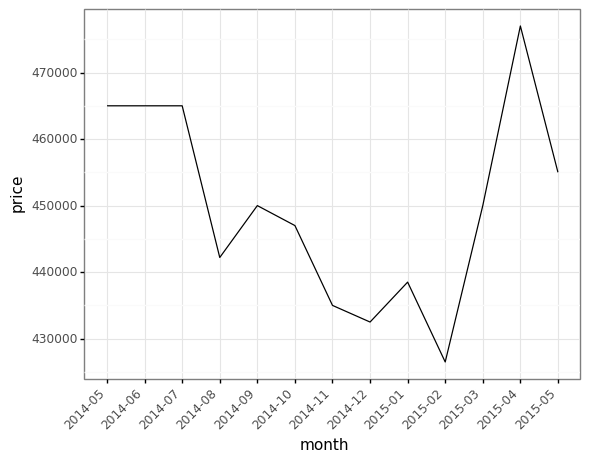

<ggplot: (8782431578330)>

In [7]:
# Let's see if the median price changes significantly over the months
data['month'] = pd.to_datetime(data.date).apply(lambda x: x.strftime('%Y-%m')) # format the Dates to yyyy-mm
grouped_by_month = data.groupby('month')[['price']].median().reset_index()

(ggplot(grouped_by_month, aes('month', 'price', group=1)) 
+ geom_line()
+ theme_bw()
+ theme(axis_text_x=element_text(rotation=45, hjust=1)))

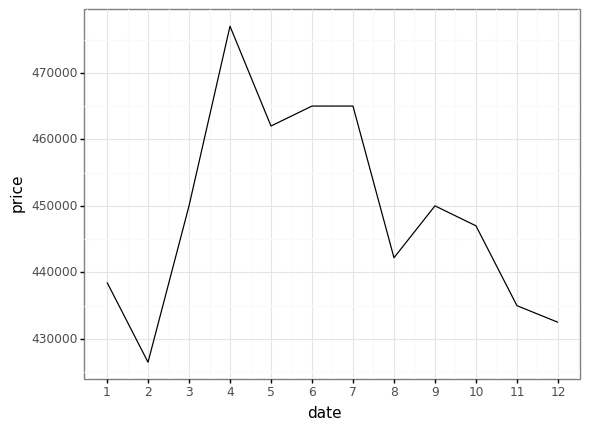

<ggplot: (-9223363254423851390)>

In [8]:
# We do indeed see that the median price changes drastically
# The price fell in winter 2014/2015
# We can also change the plot slightly so that we get the median for each calendar month from 1 (january) to 12 (december)
med_price_for_month = data.groupby(pd.DatetimeIndex(data['date']).month)[['price']].median().reset_index()

(ggplot(med_price_for_month, aes('date', 'price', group=1)) 
+ geom_line()
+ theme_bw()
+ scale_x_continuous(breaks=range(13)))

/opt/anaconda3/envs/nf/lib/python3.6/site-packages/plotnine/layer.py:372: PlotnineWarning: stat_boxplot : Removed 198 rows containing non-finite values.


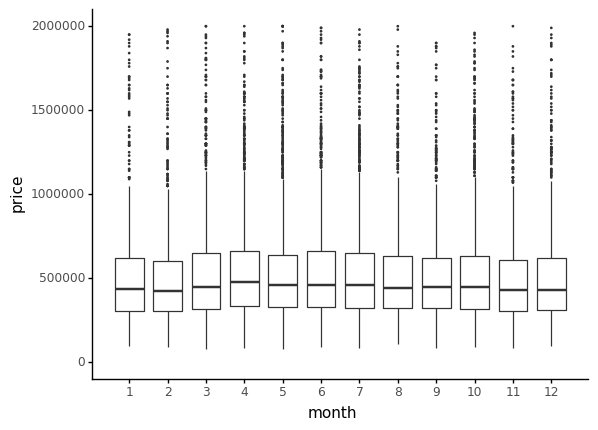

<ggplot: (-9223363254423048974)>

In [9]:
# It seems that the best month to buy is february and the best month to sell is april
# In general the prices in winter are below the prices in summer
# However since we do only have the data for one year, so we do not know if this pattern repeats throught the years
# There could be other, outside factors in play that influenced the market at these points in time

# This pattern seems also very pronounced because of the way the y-axis is scaled
# If we take another look at the same data, only with boxplots, the change in season is barely noticeable:
data['month'] = [d.month for d in data.date]

(ggplot(data, aes('month', 'price')) 
+ geom_boxplot(aes(group='month'), outlier_size = 0.1)
+ ylim(0,2000000)
+ scale_x_continuous(breaks=range(13))
+ theme_classic())

In [10]:
# We can test wether the month really is important for housing prices 
# by creating some new variables for the best months to sell and the best months to buy
# Maybe the model will get better with this information.
# Which are the important months?
med_price_for_month.sort_values('price')

,date,price
1,2,426500.0
11,12,432500.0
10,11,435000.0
0,1,438500.0
7,8,442200.0
9,10,447000.0
2,3,450000.0
8,9,450000.0
4,5,462000.0
5,6,465000.0


In [11]:
# From November to February the prices are lowest, from April to July the prices are highest
lowpricemonth, highpricemonth = [], []
for date in data.date:
    if date.month in [11,12,1,2]:
        lowpricemonth.append(1)
        highpricemonth.append(0)
    elif date.month in [4,5,6,7]:
        lowpricemonth.append(0)
        highpricemonth.append(1)
    else:
        lowpricemonth.append(0)
        highpricemonth.append(0)

data['lowpricemonth'] = lowpricemonth
data['highpricemonth'] = highpricemonth

In [12]:
# Cleanup
data.drop('month', inplace=True, axis=1)
del med_price_for_month, grouped_by_month, lowpricemonth, highpricemonth

### 3. bedrooms

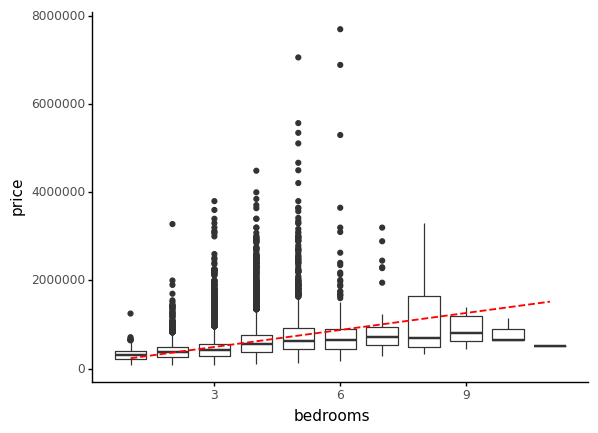

<ggplot: (8782431580694)>

In [13]:
(ggplot(data, aes('bedrooms', 'price')) 
+ geom_boxplot(aes(group='bedrooms'))
+ geom_smooth(color = 'red', size = .75, linetype = 'dashed', se=False)
+ theme_classic())

In [14]:
# Price does slightly increase with the number of bedrooms

### 4. bathrooms

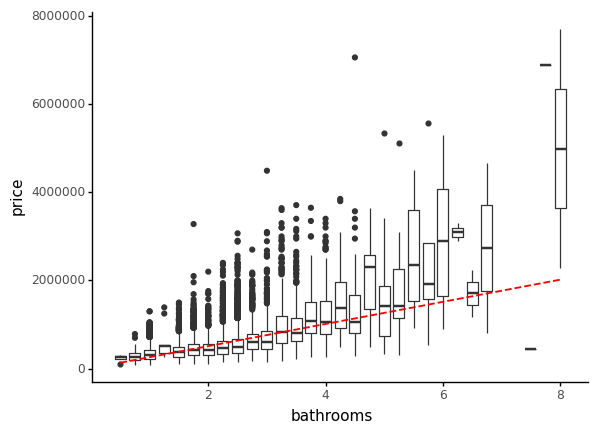

<ggplot: (-9223363254422502933)>

In [15]:
(ggplot(data, aes('bathrooms', 'price')) 
+ geom_boxplot(aes(group='bathrooms'))
+ geom_smooth(color = 'red', size = .75, linetype = 'dashed', se=False)
+ theme_classic())

In [16]:
# Same as with the bedrooms

### 5. sqft_living

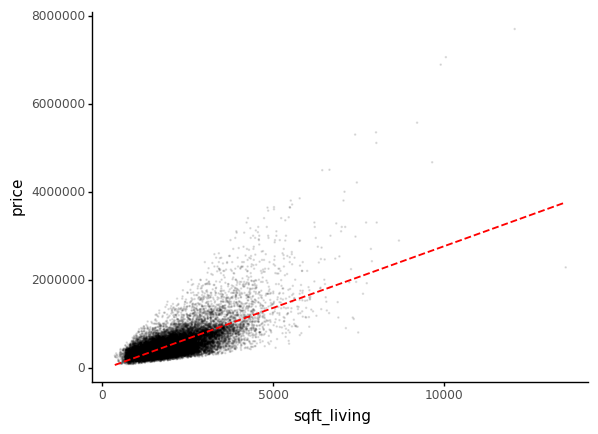

<ggplot: (8782435704079)>

In [56]:
(ggplot(data, aes('sqft_living', 'price')) 
+ geom_point(alpha=0.1, size=0.05)
+ geom_smooth(color = 'red', size = .75, linetype = 'dashed', se=False)
+ theme_classic())

In [18]:
# We see a clear rise in price with the living space

### 6. sqft_lot

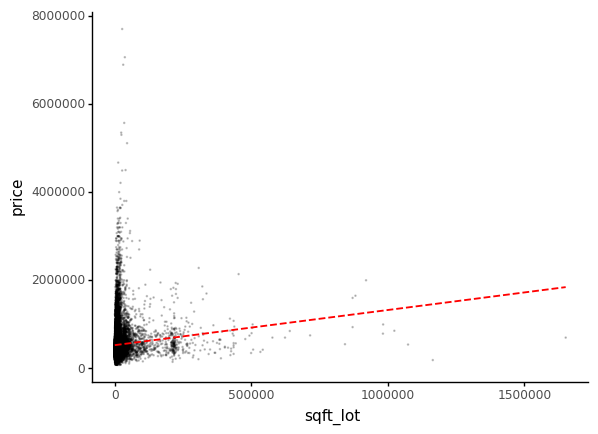

<ggplot: (-9223363254422410173)>

In [19]:
(ggplot(data, aes('sqft_lot', 'price')) 
+ geom_point(alpha=0.2, size=0.05)
+ geom_smooth(color = 'red', size = .75, linetype = 'dashed', se=False)
+ theme_classic())

In [20]:
# The relationship is less clear if we compare price to the lot area.
# This is not unexpected, as a big lot with a run down shack is typically worth less than a small lot with a villa
# Common sense thus dicates that the primary factor for price is the building and not the lot
# We do however see some correlation between the two as building a buildings worth is not totally unconnected to lot size

### 7. floors

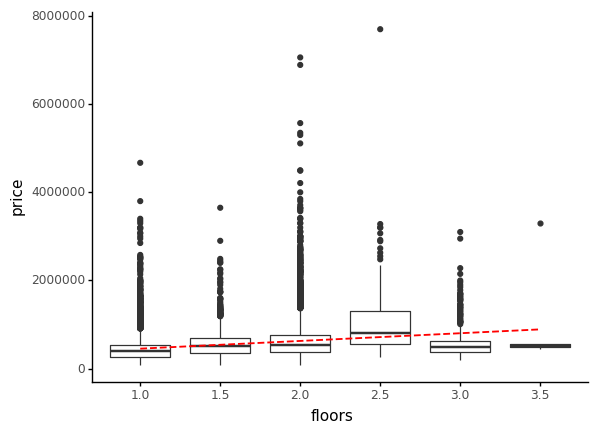

<ggplot: (-9223363254423377257)>

In [21]:
(ggplot(data, aes('floors', 'price', group=1)) 
+ geom_boxplot(aes(group='floors'))
+ geom_smooth(color = 'red', size = .75, linetype = 'dashed', se=False)
+ theme_classic())

In [22]:
# The number of floors seems to have a very weak impact on price
# We may discard this variable when we fit our model

### 8. waterfront

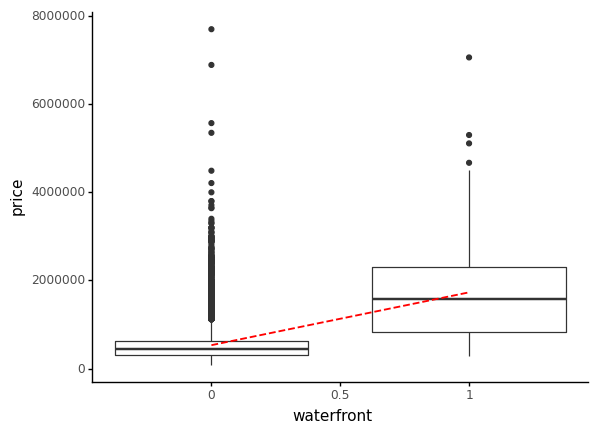

<ggplot: (-9223363254422621359)>

In [23]:
(ggplot(data.dropna(), aes('waterfront', 'price')) 
+ geom_boxplot(aes(group='waterfront'))
+ geom_smooth(color = 'red', size = .75, linetype = 'dashed', se=False)
+ theme_classic())

In [24]:
# We see that houses with waterfronts are clearly more expensive
# We still have to keep in mind that we have far fewer observations with waterfronts
# That might be a problem if we get unlucky in our train/test-split of the dataset

### 9. condition

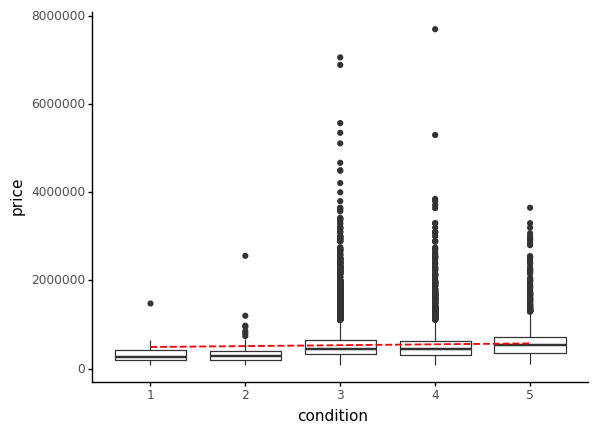

<ggplot: (8782431726845)>

In [25]:
(ggplot(data, aes('condition', 'price')) 
+ geom_boxplot(aes(group='condition'))
+ geom_smooth(color = 'red', size = .75, linetype = 'dashed', se=False)
+ theme_classic())

In [26]:
# We do see a small increase in price with condition, but not as much as one might suspect
# Especially an upgrade from 3 to 4 does not seem to be worth it for homeowners

### 10. grade

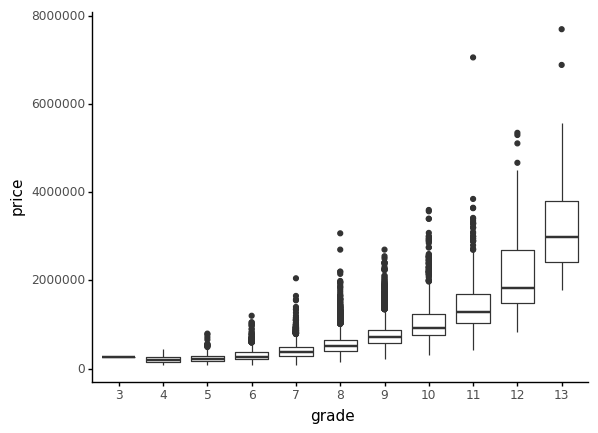

<ggplot: (-9223363254423765325)>

In [27]:
(ggplot(data, aes('grade', 'price', group=1)) 
+ geom_boxplot(aes(group='grade'))
+ theme_classic())

In [28]:
# We already saw (during cleaning) that price and grade have a non-linear relationship
# We tried to solve this problem by making each grade a dummy variable

### 11. sqft_basement

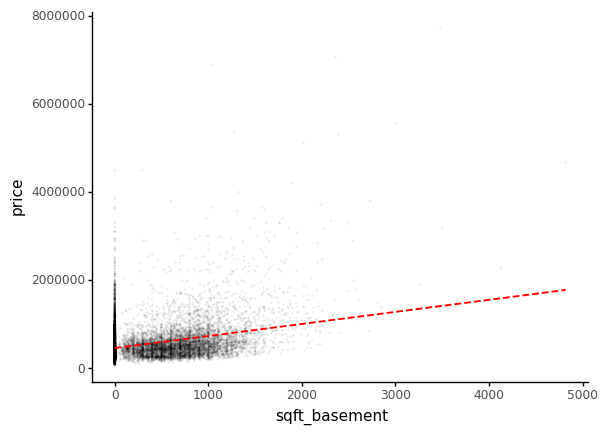

<ggplot: (-9223363254421949345)>

In [29]:
(ggplot(data.dropna(), aes('sqft_basement', 'price')) 
+ geom_point(alpha=0.05, size=0.05)
+ geom_smooth(color = 'red', size = .75, linetype = 'dashed', se=False)
+ theme_classic())

In [30]:
# The high number of houses without basements is clearly visible at the zero mark
# We can also very faintly see that many houses have rounded basement sizes in steps of 100 sqft
# Other than that we unsurprisingly see an increase in price with basement size

### 12. yr_built

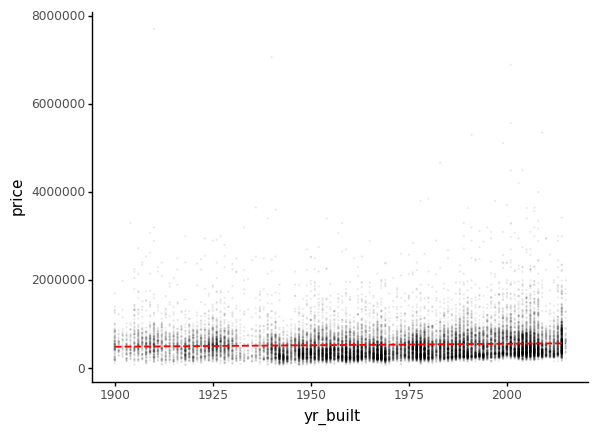

<ggplot: (8782431663182)>

In [31]:
(ggplot(data, aes('yr_built', 'price')) 
+ geom_point(alpha=0.05, size=0.05)
+ geom_smooth(color = 'red', size = .75, linetype = 'dashed', se=False)
+ theme_classic())

/opt/anaconda3/envs/nf/lib/python3.6/site-packages/plotnine/layer.py:372: PlotnineWarning: stat_boxplot : Removed 198 rows containing non-finite values.


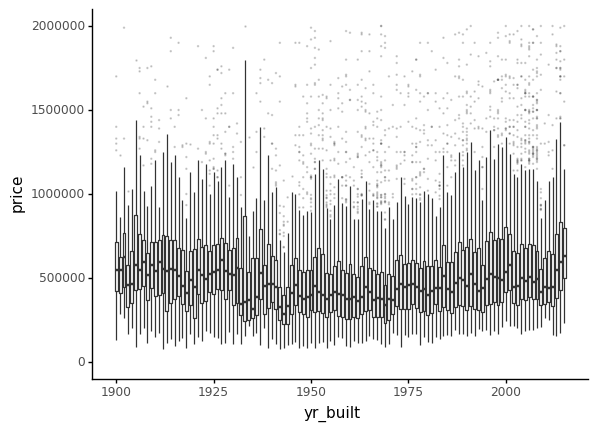

<ggplot: (8782435693653)>

In [32]:
# Surprisingly, building year seems to have almost no impact on price
# Let's take a closer look:
(ggplot(data, aes('yr_built', 'price', group=1)) 
+ geom_boxplot(aes(group='yr_built') , outlier_size = 0.01, outlier_alpha = 0.2)
+ ylim(0,2000000)
+ theme_classic())

In [33]:
# Building year seemingly does correlate with price at all
# We do see a drop in building price around 1930 though, 
# maybe the quality went down as a result of the economic crisis
# It could also be that older houses lie more towards the town centres, 
# where there is typically more expensive real estate
# After that huge drop the price slowly catches up. The newest houses are comparably expensive again

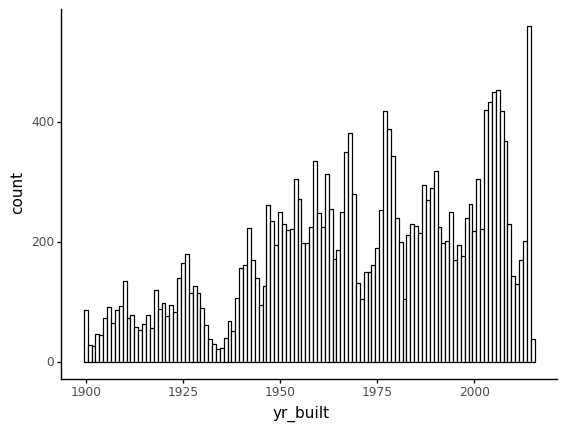

<ggplot: (-9223363254422621415)>

In [34]:
# We didn't find a correlation between price and year, but what else can we do with the year?
# Let's check how many older and newer buildings there are 
(ggplot(data, aes('yr_built')) 
+ geom_histogram(binwidth=1, color="black", fill="white")
+ theme_classic())

In [ ]:
# The great depression (1929-1933), 1973-1975 recession, early 1980s recession 
# and great recession (2007-2009) are clearly visible
# Maybe there were less houses built during those periods or they were of inferior quality and don't exist anymore

### 13. zipcode

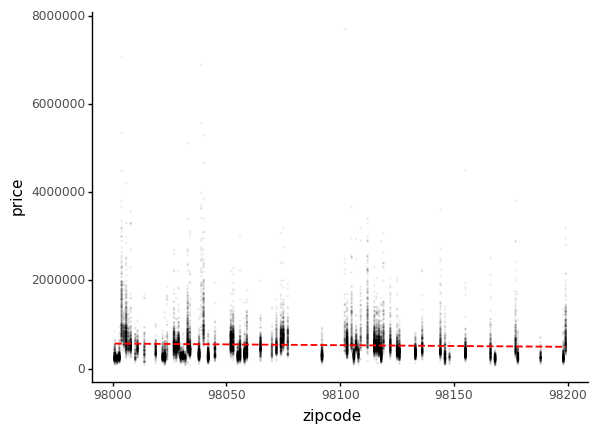

<ggplot: (8782432868672)>

In [36]:
(ggplot(data, aes('zipcode', 'price')) 
+ geom_point(alpha=0.05, size=0.05)
+ geom_smooth(color = 'red', size = .75, linetype = 'dashed', se=False)
+ theme_classic())

In [37]:
# Unsurprisingly a simple scatterplot of price vs zipcode does not reveal any useful information
# But maybe we can still find a use for the zipcodes since location should have something to do 
# with price according to common sense... 

# How about we search for zipcodes with unusually high and low median prices
# First we need to ensure that we only look at zipcodes with enough observations for this next step
# Let's go with more than 100 observations

zip_subset = data.groupby('zipcode').filter(lambda x : len(x) > 100)

zip_subset['zipcode'].nunique()

66

In [38]:
# We are down to 66 unique zipcodes from the initial 70
# Let's see if there is a noticable and significant price difference
# We order the median prices (grouped by zipcode) from lowest to highest and plot them as well as the standard deviation in price
zip_zipcodes = pd.Series(zip_subset.groupby('zipcode')['price'].median() # save the zipcodes (which are the indices)
                         .sort_values()
                         .index,
                         name = 'zipcode')
zip_price = pd.Series(zip_subset.groupby('zipcode')['price'].median() # extract the median prices
                      .sort_values()
                      .values, 
                      name = 'price')
zip_std = pd.Series(zip_subset.groupby('zipcode')['price'].std() # extract the standard deviation
                    .sort_values().
                    values.round(), 
                    name = 'std')
zip_order = pd.Series(range(len(zip_price)),  # we need the order to make the plot more readable
                      name='order')

zip_subset = pd.concat([zip_zipcodes, zip_order, zip_price, zip_std], axis=1)
zip_subset['price_upper_bound'] = zip_subset['price'] + zip_subset['std']
zip_subset['price_lower_bound'] = zip_subset['price'] - zip_subset['std']

del zip_zipcodes, zip_price, zip_std, zip_order

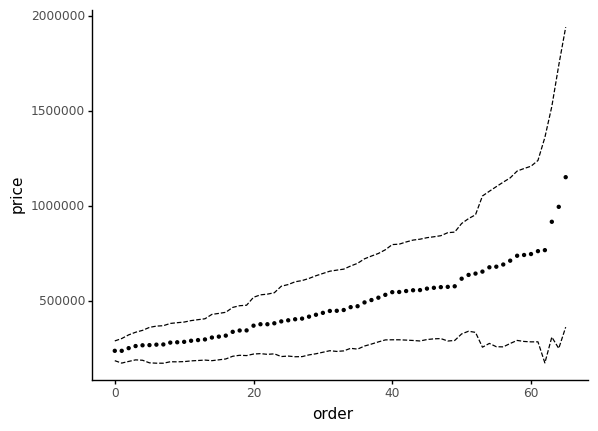

<ggplot: (-9223363254419916635)>

In [39]:
# Plot the data to see if the price difference is noticable
(ggplot(zip_subset) 
+ geom_point(aes('order','price'), size = .75)
+ geom_line(aes('order','price_upper_bound'), linetype = 'dashed')
+ geom_line(aes('order','price_lower_bound'), linetype = 'dashed')
+ theme_classic())

In [40]:
# Sadly the intervals of +/- one standard deviation do greatly overlap for all points
# Hower we can maybe take a portion of zipcodes and mark them with a new variable
# There is a visible difference between the top 3 zipcodes and the rest of them
# Maybe our model will later be able to notice this difference 

# Let's save the 'zip_subset' dataframe in a file in case we need it later
zip_subset.to_csv('zipcodes_by_price.csv')

# By the way, what are these 3 best zipcodes?
zip_subset['zipcode'][-3:].values

array([98112, 98040, 98004])

In [41]:
# Theses are (according to a zipdatamaps.com):
# 98112 - Washington Park in Seatlle - Income above 100k: 45,80% - Average Real Estate asking price: $980,578
# 98040 - Mercer Island (Washington) - Income above 100k: 59,30% - Average Real Estate asking price: $1,411,990
# 98004 - Bellevue (Washington)      - Income above 100k: 41,40% - Average Real Estate asking price: $1,500,630
# These three areas lie right next to each other on the map and boast some impressive demographic values. 
# A sample matching with some of the other zipcodes indicate that we might be onto something here.

# Lets make a new column 'topzip' in the original dataset
topzip = []
for zipcode in data['zipcode']:
    if zipcode in zip_subset['zipcode'][-3:].values:
        topzip.append(1)
    else :
        topzip.append(0)
data['topzip'] = topzip

# The difference between zipcodes is much less pronounced in the bottom ones
# No matter where we would place a similar cutoff to the top 3, 
# the difference between those that made it and those that does seem neglectable
# That is why we will not use a 'bottomzip' variable or similar for now

### 15. lat & long

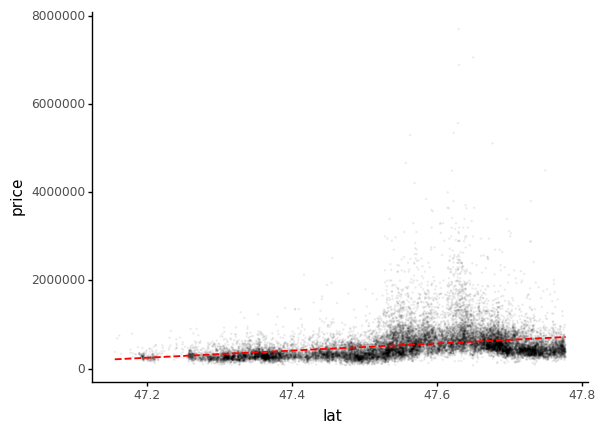

<ggplot: (-9223363254423722829)>

In [42]:
(ggplot(data, aes('lat', 'price')) 
+ geom_point(alpha=0.05, size=0.05)
+ geom_smooth(color = 'red', size = .75, linetype = 'dashed', se=False)
+ theme_classic())

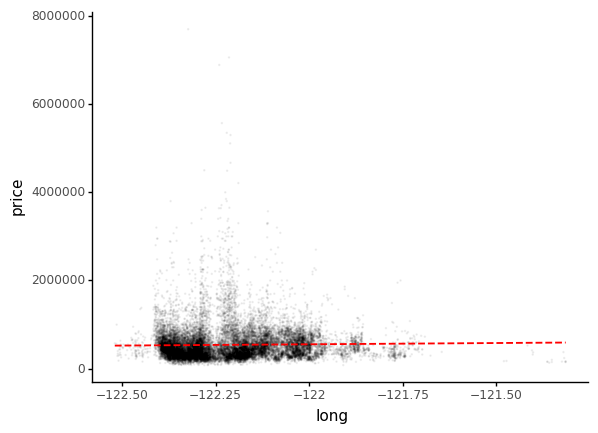

<ggplot: (-9223363254419318370)>

In [43]:
# There does seem to be a slight correlation with latitude. 
# The more north we go, the better the pricing becomes
# How about longitude?
(ggplot(data, aes('long', 'price')) 
+ geom_point(alpha=0.05, size=0.05)
+ geom_smooth(color = 'red', size = .75, linetype = 'dashed', se=False)
+ theme_classic())

In [44]:
# Definitely less pronounced, if there even is a relationship

### 15. sqft_living15

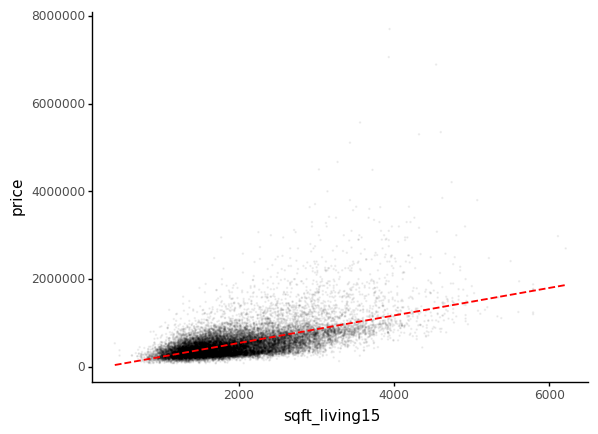

<ggplot: (-9223363254449962373)>

In [48]:
# There does seem to be a slight correlation with latitude. 
# The more north we go, the better the pricing becomes
# How about longitude?
(ggplot(data, aes('sqft_living15', 'price')) 
+ geom_point(alpha=0.05, size=0.05)
+ geom_smooth(color = 'red', size = .75, linetype = 'dashed', se=False)
+ theme_classic())

In [49]:
# price and sqft_living15 seem to be correlated
# if your neighbours have bigger houses, you may be living in a more affluent neighbourhood
# thus, your house is likely also worth more

### 16. sqft_lot15

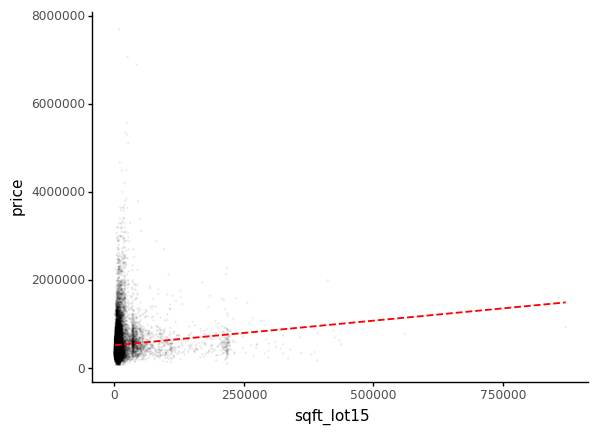

<ggplot: (8782405013403)>

In [50]:
# There does seem to be a slight correlation with latitude. 
# The more north we go, the better the pricing becomes
# How about longitude?
(ggplot(data, aes('sqft_lot15', 'price')) 
+ geom_point(alpha=0.05, size=0.05)
+ geom_smooth(color = 'red', size = .75, linetype = 'dashed', se=False)
+ theme_classic())

In [51]:
# ggplot does detect some kind of correlation, 
# the difference between sqft_living15 and sqft_lot15 looks similar to sqft_living and sqft_lot

In [52]:
# YEAR_BUILT - SQUARE FEET
# check for multicorrelation

In [53]:
data.to_pickle('King_County_House_prices_dataset_EXPLORED.pkl')

In [54]:
# 'Accent', 'Accent_r', 'Blues', 'Blues_r', 'BrBG', 'BrBG_r', 'BuGn', 'BuGn_r', 'BuPu', 'BuPu_r', 'CMRmap', 
# 'CMRmap_r', 'Dark2', 'Dark2_r', 'GnBu', 'GnBu_r', 'Greens', 'Greens_r', 'Greys', 'Greys_r', 'OrRd', 'OrRd_r', 
# 'Oranges', 'Oranges_r', 'PRGn', 'PRGn_r', 'Paired', 'Paired_r', 'Pastel1', 'Pastel1_r', 'Pastel2', 'Pastel2_r', 
# 'PiYG', 'PiYG_r', 'PuBu', 'PuBuGn', 'PuBuGn_r', 'PuBu_r', 'PuOr', 'PuOr_r', 'PuRd', 'PuRd_r', 'Purples', 
# 'Purples_r', 'RdBu', 'RdBu_r', 'RdGy', 'RdGy_r', 'RdPu', 'RdPu_r', 'RdYlBu', 'RdYlBu_r', 'RdYlGn', 'RdYlGn_r', 
# 'Reds', 'Reds_r', 'Set1', 'Set1_r', 'Set2', 'Set2_r', 'Set3', 'Set3_r', 'Spectral', 'Spectral_r', 'Wistia', 
# 'Wistia_r', 'YlGn', 'YlGnBu', 'YlGnBu_r', 'YlGn_r', 'YlOrBr', 'YlOrBr_r', 'YlOrRd', 'YlOrRd_r', 'afmhot', 
# 'afmhot_r', 'autumn', 'autumn_r', 'binary', 'binary_r', 'bone', 'bone_r', 'brg', 'brg_r', 'bwr', 'bwr_r', 
# 'cividis', 'cividis_r', 'cool', 'cool_r', 'coolwarm', 'coolwarm_r', 'copper', 'copper_r', 'cubehelix', 
# 'cubehelix_r', 'flag', 'flag_r', 'gist_earth', 'gist_earth_r', 'gist_gray', 'gist_gray_r', 'gist_heat', 
# 'gist_heat_r', 'gist_ncar', 'gist_ncar_r', 'gist_rainbow', 'gist_rainbow_r', 'gist_stern', 'gist_stern_r', 
# 'gist_yarg', 'gist_yarg_r', 'gnuplot', 'gnuplot2', 'gnuplot2_r', 'gnuplot_r', 'gray', 'gray_r', 'hot', 'hot_r',
# 'hsv', 'hsv_r', 'icefire', 'icefire_r', 'inferno', 'inferno_r', 'jet', 'jet_r', 'magma', 'magma_r', 'mako', 
# 'mako_r', 'nipy_spectral', 'nipy_spectral_r', 'ocean', 'ocean_r', 'pink', 'pink_r', 'plasma', 'plasma_r', 
# 'prism', 'prism_r', 'rainbow', 'rainbow_r', 'rocket', 'rocket_r', 'seismic', 'seismic_r', 'spring', 'spring_r', 
# 'summer', 'summer_r', 'tab10', 'tab10_r', 'tab20', 'tab20_r', 'tab20b', 'tab20b_r', 'tab20c', 'tab20c_r', 
# 'terrain', 'terrain_r', 'turbo', 'turbo_r', 'twilight', 'twilight_r', 'twilight_shifted', 'twilight_shifted_r', 
# 'viridis', 'viridis_r', 'vlag', 'vlag_r', 'winter', 'winter_r'


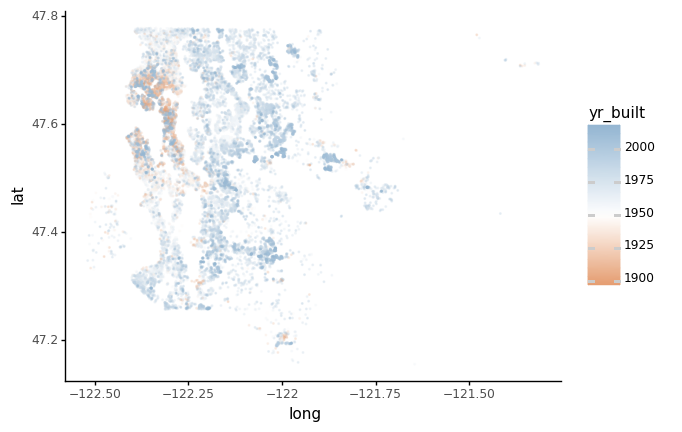

<ggplot: (8782411501558)>

In [96]:
# There does seem to be a slight correlation with latitude. 
# The more north we go, the better the pricing becomes
# How about longitude?
(ggplot(data, aes('long', 'lat')) 
+ geom_point(aes(colour='yr_built'), alpha=0.2, size=0.2)
+ theme_classic()
+ scale_color_gradient2(low="#dd8047", 
                        mid="white", 
                        high="#94b6d2", 
                        midpoint=1950
                       ))